In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

import pickle
from glob import glob

import sys
sys.path.append('../')
from exploratory_projects.Maestro.maestro import calibration
import maestro
from maestro import frame 

print(f'Importing from {maestro.__file__}')

Importing from /home/kyle/Documents/exploratory_projects/Maestro/dev_notebooks/../maestro/__init__.py


# Concepts behind calibration frames

When capturing the night sky, the objects we try to capture are often so faint that photon counts end up being dominated not by the source we want to image, but rather photons from everything else and even imperfections in our own camera. If we were to process raw photographs of the sky we would find numerous issues from grainy images, to bad colors, to vignette. All of these will detract from the final nebula or galaxy.

Thankfully, science has our back, and we've developed rather simplistic techniques with incredible potency in increasing the fidelity of our final image which end up being the exact same techniques used to create images from Hubble or even JWST!  To start, we need to understand the theory behind what our camera is actually doing when taking an image.

## What is an image?

While older cameras might use photographic film which crystalizes when exposed to light, modern cameras leverage Charge-Coupled Devices (CCD). These tiny circuits, when exposed to light will generate a small charge proportional to the amount of light hitting the surface. As more light hits it, more charge builds up. Then, when the camera closes, the charge is held in place until a 'shift register' mechanism moves all of the charge to a device which can measure the amount of charge that each pixel recieved. This means that the amount of charge read is roughly proportional to the amount of light that pixel recived and therefor, the brightness of that pixel in the resulting image, $b$, is proportional to the amount of light recieved. 

$$ b \propto q \propto n_{\rm{photons}} $$

In a perfect world, this would be the only equation you would need for astrophotography. Sadly, imperfection is the name of the game and we have to deal with noise too. To quantify a particular pixel's response to all sources of noise, we need an equation which ecapsulates them all. We can do that through the following equation:

$$ \sigma^2_{\rm{total}}(t) = \sigma^2_{\rm{thermal}}(T)(t) + \sigma^2_{\rm{read}} + \sigma^2_{\rm{sky}}(t) + \sigma^2_{\rm{source}}(t) $$


There are 4 sources of noise in this equation:

1. Thermal Noise
2. Read noise
3. Background (sky) noise
4. Source (shot) noise 


### Thermal noise

When taking an image, a camera measures the built up charge of a CCD. While ideally this charge would result purely from photons from our source, we can get all sorts of other processes that can create a residual charge as well. Cheif among these is thermal processes. Since the detector itself has some non-zero temperature, thanks to blackbody radiation, the CCD and other parts of your camera will produce some amount of photon radiation. When these photons land on the CCD, just as if they were a galaxy, the CCD will build up charge. In general the higher the temperature of the camera, the more thermal noise you will find.

In astrophotography, we can figure out the average amount of thermal noise is in our camera through calibration frames often called "Darks" or "Dark frames". These must be taken at the same temperature that the Lights or Light frames were taken and with the exact same settings including focal length/zoom, focus, exposure time, ISO and white balance, though this time, the goal isn't to image anything at all. Instead they should be taken with the lens cap **on**. It may sound weird, but if we want to figure out how much thermal noise we expect in our CCD, we need to count how much thermal noise we have in the absense of any typical sources of light.

###


## Constructing a master bias frame

In order to calculate how much noise our CCD creates when reading in the data from each pixel, we need to load in all of our bias frames and combine them.

blah, blah


Medians should be more robust to hot pixels, but we can try both.
- Maybe there's a way to calculate the median of the pixels without loading all of them in, but I don't know it and couldn't find it online
- Averages can absolutely be calculated without loading them in, but if we want to clip extrema, we need to anyway

The pixel response equation:

$$ q_{\rm{total}} = R(N_{\rm{th}}(T) + N_{\rm{rd}} + N_{\rm{src}}) $$

Where $q$ is the measured sub-pixel values, $R(N)$ is the response function which converts the counts (analogous to the number of photons) into a sub-pixel value, $N_{\rm{th}}(T)$ are the thermal counts which come from the camera's temperature $T$, $N_{\rm{rd}}$ is the number of counts introduced into the sub-pixel by reading it, and $N_{\rm{src}}$ is the number of counts from the source itself. 

We can use this equation to estimate our final count response through a simple inversion

$$ q_{\rm{total}} = R(N_{\rm{th}}(T)) + R(N_{\rm{rd}}) + R(N_{\rm{src}}) $$

$$ R(N_{\rm{src}}) = q_{\rm{total}} - R(N_{\rm{th}}(T)) + R(N_{\rm{rd}}) $$

We can make a small assumption that the response function itself is linear with the number of counts $R(N) \approx r*N$ to derive our final source count total as:

$$ N_{\rm{src}} = \frac{q_{\rm{total}} - r*N_{\rm{th}}(T) + r*N_{\rm{rd}}}{r} $$

In this final equation, we can see the equation for which we will need to solve for each sub-pixel. To do so, we will need to estimate 3 things:
1. $r*N_{\rm{th}}(T)$ - The sub-pixel contributions from thermal photons
2. $r*N_{\rm{rd}}$ - The sub-pixel contributions from read noise 
3. $r$ - The response of the sub-pixel to all sources.

It may seem a bit odd to leave in the response $r$ in both the numerator and denominator, but, since we cannot isolate the effects of the response when measuring the thermal counts or read counts, it is much easier to keep them in this form and tranform them at the end. 

So how do we do this? With **bias**, **flat**, and **dark** frames

In [ ]:
bias_files = glob('../photos/bias/*.CR3')
flat_files = glob('../photos/flats/*.CR3')
dark_files = glob('../photos/darks/*.CR3')

master_bias = calibration.Bias(bias_files, method='median', keep_individual=False)
master_flat = calibration.Flat(flat_files, method='median', keep_individual=False)
master_dark = calibration.Dark(dark_files, method='median', keep_individual=False)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

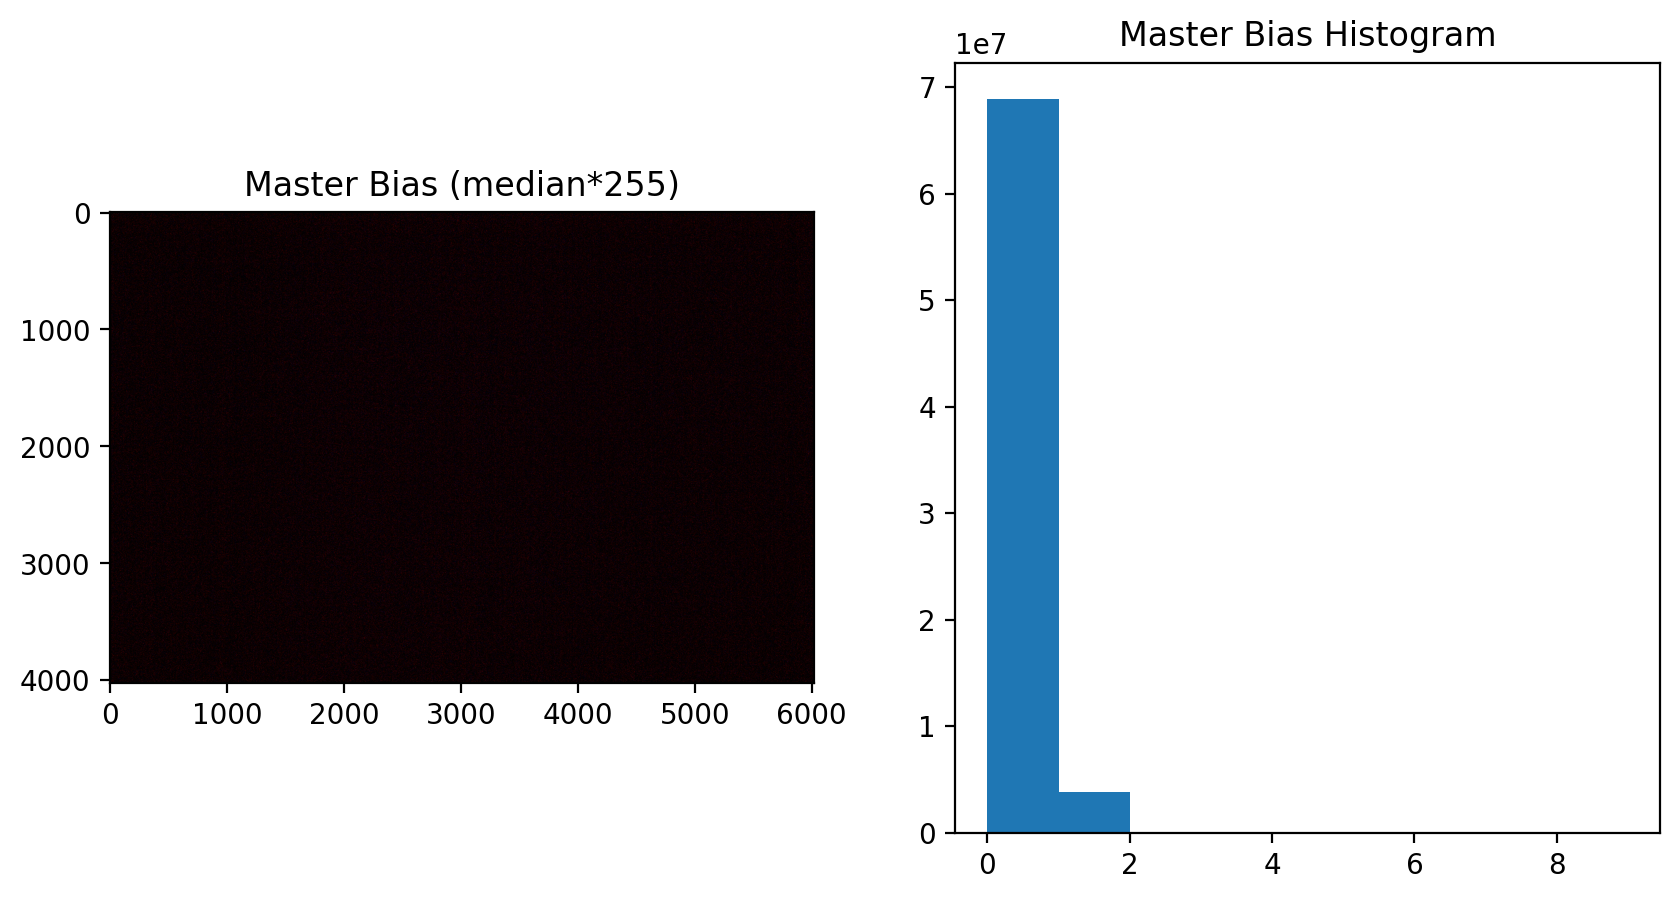

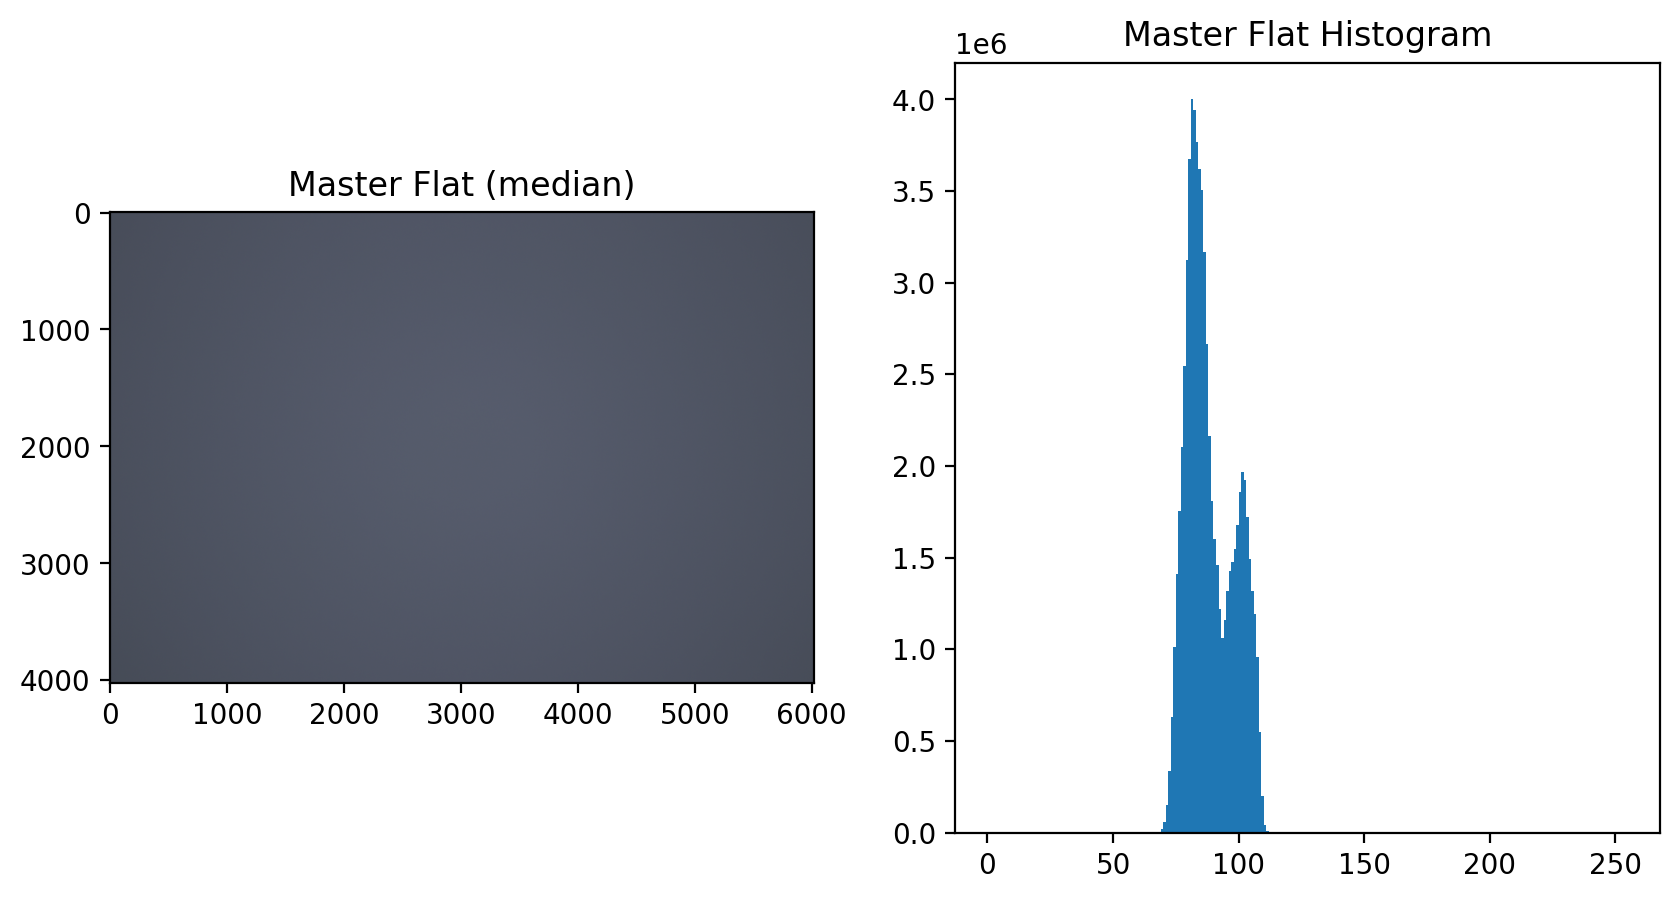

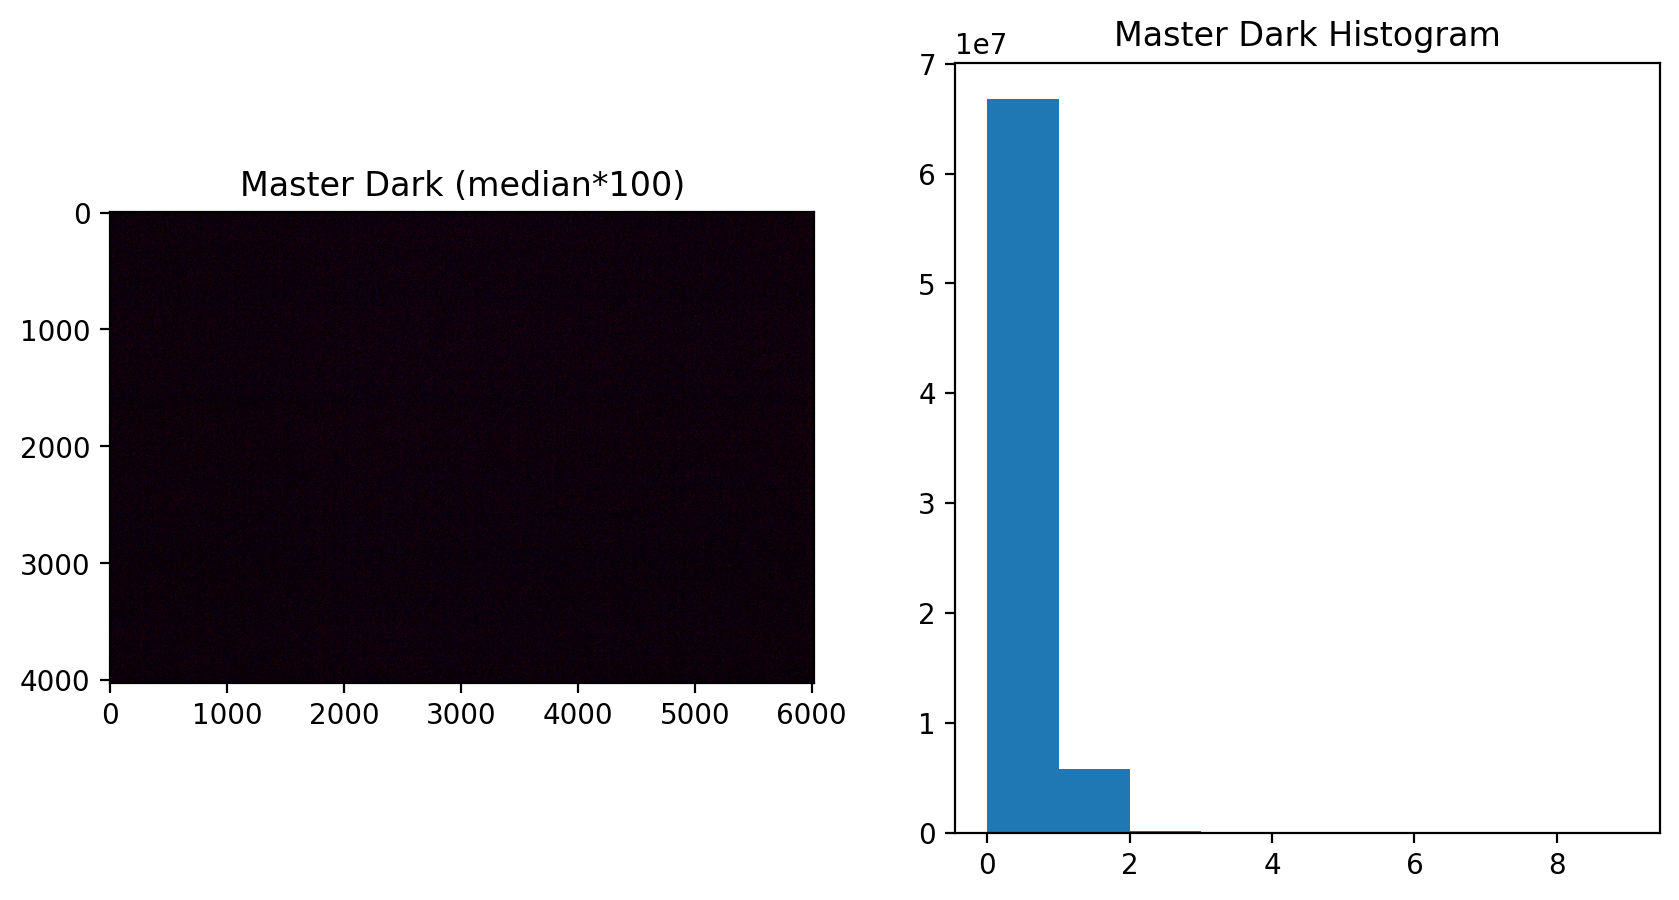

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(master_bias.rgb*100)
axes[0].set_title('Master Bias (median*100)')

axes[1].hist(master_bias.rgb.flatten(), bins=np.arange(0, 10, 1))
axes[1].set_title('Master Bias Histogram')
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(master_flat.rgb)
axes[0].set_title('Master Flat (median)')

axes[1].hist(master_flat.rgb.flatten(), bins=np.arange(0, 256, 1))
axes[1].set_title('Master Flat Histogram')
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(master_dark.rgb*100)
axes[0].set_title('Master Dark (median*100)')

axes[1].hist(master_dark.rgb.flatten(), bins=np.arange(0, 10, 1))
axes[1].set_title('Master Dark Histogram')
plt.show()

## Noise subtraction of lights

In [ ]:
# Lets load in our lights